In [10]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

training_data = []
testing_data = [] 

class prep_data():
    def __init__(self,file_path):
        self.file_path = file_path
        if not os.path.exists(self.file_path):
            print("this file path doesnt exist")
        try:
            data_pd = pd.read_csv(self.file_path)
        except Exception as e:
            print("Error occured during loading the csv fule")
            return
        data_len = data_pd.shape[0]
        test_len = int(data_len*0.2)
        train_len = data_len - test_len

        for i in tqdm(range(train_len)):
            training_data.append((torch.tensor(data_pd.iloc[i,1:].values,dtype = torch.float32),data_pd.iloc[i,0]))

        for i in tqdm(range(train_len, data_len)):
            testing_data.append((torch.tensor(data_pd.iloc[i,1:].values,dtype = torch.float32),data_pd.iloc[i,0]))
        
file_path = '/Users/Vedant Dutta/Desktop/hand_sign_set/sign_mnist_train.csv'
prep_dat = prep_data(file_path)
    

100%|████████████████████████████████████████████████████████████████████████████| 5491/5491 [00:00<00:00, 8884.20it/s]


In [11]:
print(len(training_data))

21964


**Now we can go ahead and make the network that is as specified in the assignment.**


**conv layer1** : 1 input channel, 32 output channels, kenrel_size = 3,3 stride =1, activation used = relu

**conv layer2** : 32 input channels, 64 output channels, kernel_size = 3,3, stride = 1, activation used = relu

**max pool layer** : window size = 2,2, stride = 2.

**fully connected layer1** : 512 units, activation used = Relu

**dropout layer**  : dropout rate = 0.28

**output layer** : fully connected, 26 neurons with softmax activation for logit probablity output for each of the 26 classes.

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,32, kernel_size = (3,3), stride = 1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32,64,kernel_size = (3,3), stride = 1)
        self.bn2 = nn.BatchNorm2d(64)

        self.to_lin = None
        x = torch.rand(28,28).view(-1,1,28,28)
        self.temp_forward(x)
        self.fc1 = nn.Linear(self.to_lin, 512)
        self.fc2 = nn.Linear(512,26)
        self.drop_out = nn.Dropout(p = 0.28, inplace = False)

    def temp_forward(self,x):
        x = F.relu(self.conv1(x))
        x = self.bn1(x)
        x = F.relu(self.conv2(x))
        x = self.bn2(x)
        x = F.max_pool2d(x,kernel_size = (2,2))

        if self.to_lin == None:
            self.to_lin = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return x
             
    def forward(self,x):
        x = self.temp_forward(x)
        x = x.view(-1,self.to_lin)
        x = F.relu(self.fc1(x))
        x = self.drop_out(x)
        x = self.fc2(x)
        #x = F.softmax(x, dim = 1)
        return x
                
net = Net()     
summary(net, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
       BatchNorm2d-2           [-1, 32, 26, 26]              64
            Conv2d-3           [-1, 64, 24, 24]          18,496
       BatchNorm2d-4           [-1, 64, 24, 24]             128
            Linear-5                  [-1, 512]       4,719,104
           Dropout-6                  [-1, 512]               0
            Linear-7                   [-1, 26]          13,338
Total params: 4,751,450
Trainable params: 4,751,450
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.90
Params size (MB): 18.13
Estimated Total Size (MB): 19.03
----------------------------------------------------------------


So, now the network architecture has been made and now we can set the optimizer, loss function etc for the means of training

In [13]:
import torch.optim as optim

optimizer = optim.Adam(net.parameters(), lr = 0.001)
loss_fn = nn.CrossEntropyLoss()
val_len = int(len(training_data)*0.2)
X_train = torch.stack([(i[0].view(28,28))/255.0 for i in training_data[:-val_len]])
X_val = torch.stack([(i[0].view(28,28))/255.0 for i in training_data[-val_len:]])
y_train = torch.tensor([int(i[1]) for i in training_data[:-val_len]])
y_val = torch.tensor([int(i[1]) for i in training_data[-val_len:]])


num_epochs = 50




In [17]:
num_epochs = 20
batch_size = 50

losses = []
training_acc = []
for epoch in range(num_epochs):
    epoch_loss = 0
    num_correct = 0
    total = 0
    for i in tqdm(range(0,len(X_train),batch_size)):
        x = X_train[i:i+batch_size].view(-1,1,28,28)
        batch_y = y_train[i:i+batch_size]
        optimizer.zero_grad()
        ops = net(x)
        loss = loss_fn(ops,batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    for j in range(len(X_val)):
        x1 = X_val[j].view(-1,1,28,28)
        y_1 = y_val[j]
        op = net(x1)
        _,predclass = torch.max(op,1)
        if predclass == y_1:
            num_correct+= 1
        total += 1
    temp_acc = num_correct/total
    training_acc.append(temp_acc)
    avg_epoch_loss = epoch_loss/(len(X)//batch_size)
    losses.append(avg_epoch_loss)
    print(f"epoch {epoch+1}/{num_epochs} : loss = {avg_epoch_loss:.4f}")
    print(f"epoch {epoch+1}/{num_epochs} : accuracy = {(temp_acc*100):.4f}%")
    
   

100%|████████████████████████████████████████████████████████████████████████████████| 352/352 [00:30<00:00, 11.54it/s]


epoch 1/20 : loss = 0.0747
epoch 1/20 : accuracy = 97.8825%


100%|████████████████████████████████████████████████████████████████████████████████| 352/352 [00:31<00:00, 11.32it/s]


epoch 2/20 : loss = 0.0108
epoch 2/20 : accuracy = 99.1348%


100%|████████████████████████████████████████████████████████████████████████████████| 352/352 [00:33<00:00, 10.44it/s]


epoch 3/20 : loss = 0.0140
epoch 3/20 : accuracy = 98.8843%


100%|████████████████████████████████████████████████████████████████████████████████| 352/352 [00:34<00:00, 10.12it/s]


epoch 4/20 : loss = 0.0317
epoch 4/20 : accuracy = 98.8616%


100%|████████████████████████████████████████████████████████████████████████████████| 352/352 [00:37<00:00,  9.51it/s]


epoch 5/20 : loss = 0.0306
epoch 5/20 : accuracy = 99.3169%


100%|████████████████████████████████████████████████████████████████████████████████| 352/352 [00:33<00:00, 10.39it/s]


epoch 6/20 : loss = 0.0232
epoch 6/20 : accuracy = 99.2942%


100%|████████████████████████████████████████████████████████████████████████████████| 352/352 [00:31<00:00, 11.06it/s]


epoch 7/20 : loss = 0.0288
epoch 7/20 : accuracy = 99.1348%


100%|████████████████████████████████████████████████████████████████████████████████| 352/352 [00:32<00:00, 10.71it/s]


epoch 8/20 : loss = 0.0112
epoch 8/20 : accuracy = 99.5674%


100%|████████████████████████████████████████████████████████████████████████████████| 352/352 [00:35<00:00,  9.96it/s]


epoch 9/20 : loss = 0.0152
epoch 9/20 : accuracy = 98.9754%


100%|████████████████████████████████████████████████████████████████████████████████| 352/352 [00:31<00:00, 11.01it/s]


epoch 10/20 : loss = 0.0261
epoch 10/20 : accuracy = 98.9071%


100%|████████████████████████████████████████████████████████████████████████████████| 352/352 [00:31<00:00, 11.05it/s]


epoch 11/20 : loss = 0.0078
epoch 11/20 : accuracy = 99.2031%


100%|████████████████████████████████████████████████████████████████████████████████| 352/352 [00:32<00:00, 10.79it/s]


epoch 12/20 : loss = 0.0118
epoch 12/20 : accuracy = 99.6585%


100%|████████████████████████████████████████████████████████████████████████████████| 352/352 [00:32<00:00, 10.99it/s]


epoch 13/20 : loss = 0.0053
epoch 13/20 : accuracy = 99.3852%


100%|████████████████████████████████████████████████████████████████████████████████| 352/352 [00:31<00:00, 11.05it/s]


epoch 14/20 : loss = 0.0099
epoch 14/20 : accuracy = 98.8843%


100%|████████████████████████████████████████████████████████████████████████████████| 352/352 [00:31<00:00, 11.22it/s]


epoch 15/20 : loss = 0.0213
epoch 15/20 : accuracy = 99.5219%


100%|████████████████████████████████████████████████████████████████████████████████| 352/352 [00:31<00:00, 11.35it/s]


epoch 16/20 : loss = 0.0251
epoch 16/20 : accuracy = 99.4763%


100%|████████████████████████████████████████████████████████████████████████████████| 352/352 [00:31<00:00, 11.27it/s]


epoch 17/20 : loss = 0.0157
epoch 17/20 : accuracy = 99.3625%


100%|████████████████████████████████████████████████████████████████████████████████| 352/352 [00:33<00:00, 10.53it/s]


epoch 18/20 : loss = 0.0106
epoch 18/20 : accuracy = 99.6585%


100%|████████████████████████████████████████████████████████████████████████████████| 352/352 [00:31<00:00, 11.30it/s]


epoch 19/20 : loss = 0.0022
epoch 19/20 : accuracy = 99.8862%


100%|████████████████████████████████████████████████████████████████████████████████| 352/352 [00:31<00:00, 11.35it/s]


epoch 20/20 : loss = 0.0109
epoch 20/20 : accuracy = 99.4763%


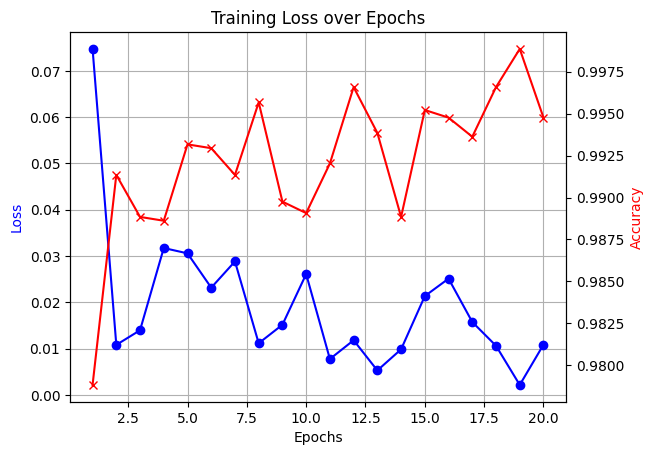

In [18]:
plt.plot(range(1,num_epochs+1),losses, marker = 'o',color = 'b')
plt.title('Training Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss', color = 'b')
plt.grid(True)
ax2 = plt.gca().twinx()
ax2.plot(range(1, num_epochs+1), training_acc, marker='x', color='r', label='Accuracy')
ax2.set_ylabel('Accuracy', color='r')
plt.show()

Now we can see the the accuracy on the testing dataset

In [19]:
X_test = torch.stack([i[0].view(28,28) for i in testing_data])
y_test = torch.tensor([int(i[1]) for i in testing_data])
correct_preds = 0
tot = 0
for i in range(len(X_test)):
    x_tmp = X_test[i].view(-1,1,28,28)
    op1 = net(x_tmp)
    _,pred = torch.max(op1,1)
    if pred == y_test[i]:
        correct_preds += 1
    tot += 1
acc = correct_preds/tot
print(f"The accuracy as seen on the testing set is : {(acc*100):.4f}%")

The accuracy as seen on the testing set is : 97.4868%
